In [18]:
import pandas as pd
import datetime
import pickle
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 700)

Weighted sum of SOD to predict PMI/ADD.

In [7]:
# import data
g_data = pd.read_pickle('../data/Gelderman_SOD_cohort/unique_img_triplets_w_ADD.csv')
print(len(g_data))
display(g_data.head())
display(g_data.info())

174


,new_id,img_head,correct_img_date,date_placed_ARF,PMI_days,age_at_death,sex,est_weight_lb,est_stature_in,true_SOD_G_head,BP_of_true_SOD_G,donor_date,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs,TDS,ADD_thres0,ADD_thres5,ADD_thres10,ADD_thres15,ADD_thres20,ADD_thres25,ADD_thres30
0,004,00400124.12.JPG,2018-01-24,2018-01-09,15.0,77.0,Female,180.0,64.000000,3.0,head,00400124,00400124.07.JPG,3.0,00400124.10.JPG,3.0,9.0,73.881146,65.115868,32.350972,0.000000,0.000000,0.000000,0.00000
1,006,00600212.07.JPG,2018-02-12,2018-01-09,34.0,81.0,Male,NaN,NaN,3.0,head,00600212,00600212.25.JPG,3.0,00600212.06.JPG,3.0,9.0,168.917222,134.917431,47.343333,0.000000,0.000000,0.000000,0.00000
2,00b,00b00525.08.JPG,2016-05-25,2016-03-07,79.0,38.0,Male,516.0,73.000039,5.0,head,00b00525,00b00525.04.JPG,5.0,00b00525.27.JPG,3.0,13.0,1326.323441,1326.323441,1279.608857,983.358857,391.756402,0.000000,0.00000
3,00b,00b00818.07.JPG,2016-08-18,2016-03-07,164.0,38.0,Male,516.0,73.000039,6.0,head,00b00818,00b00818.05.JPG,6.0,00b00818.11.JPG,3.0,15.0,3552.068684,3552.068684,3505.354100,3209.104100,2617.501645,1785.331086,30.05625
4,00d,00d10116.07.JPG,2019-01-16,2018-11-27,50.0,73.0,Male,235.0,73.000039,5.0,head,00d10116,00d10116.04.JPG,4.0,00d10116.06.JPG,4.0,13.0,317.835928,268.610789,126.581344,30.420863,0.000000,0.000000,0.00000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 174 entries, 0 to 173
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   new_id            174 non-null    object        
 1   img_head          174 non-null    object        
 2   correct_img_date  174 non-null    datetime64[ns]
 3   date_placed_ARF   174 non-null    datetime64[ns]
 4   PMI_days          174 non-null    float64       
 5   age_at_death      173 non-null    float64       
 6   sex               173 non-null    object        
 7   est_weight_lb     162 non-null    float64       
 8   est_stature_in    168 non-null    float64       
 9   true_SOD_G_head   174 non-null    float64       
 10  BP_of_true_SOD_G  174 non-null    object        
 11  donor_date        174 non-null    object        
 12  img_torso         174 non-null    object        
 13  true_SOD_G_torso  174 non-null    float64       
 14  img_limbs         174 non-

None

# PMI regression

## Process data

In [8]:
pmi_data = g_data[['true_SOD_G_head', 'true_SOD_G_torso', 'true_SOD_G_limbs', 'PMI_days']].copy()

In [9]:
# create X and y dataframes
X = pmi_data.drop('PMI_days', axis=1)
display(X.head(2))
print(X.shape)

y = pmi_data[['PMI_days']]
display(y.head(2))
print(y.shape)

,true_SOD_G_head,true_SOD_G_torso,true_SOD_G_limbs
0,3.0,3.0,3.0
1,3.0,3.0,3.0


(174, 3)


,PMI_days
0,15.0
1,34.0


(174, 1)


In [11]:
# fit model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [16]:
# make predictions
y_pred = model.predict(X)

In [20]:
# The coefficients
print("Coefficients: \n", model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y, y_pred))
print("Root mean squared error: %.2f" % math.sqrt(mean_squared_error(y, y_pred)))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y, y_pred))

Coefficients: 
 [[-1.75282529 17.54466052  5.20473702]]
Mean squared error: 2020.56
Root mean squared error: 44.95
Coefficient of determination: 0.20


In [13]:
r_sq = model.score(X, y)
print(f"coefficient of determination: {r_sq}")

coefficient of determination: 0.20425740437375384


In [14]:
print(f"intercept: {model.intercept_}")

intercept: [-23.17811619]


In [15]:
print(f"slope: {model.coef_}")

slope: [[-1.75282529 17.54466052  5.20473702]]


### Derive predicted PMI from predicted ADD
This will require the true PMI and weather history per donor_date. See 03_sod_pmi_to_add.ipynb for ADD calculations details. We will now go backwards, meaning deriving the PMI from the predicted ADD. Note, to align with Gelderman's study, a daily temperature below 0 degrees C is counted as 0 since decomposition stops below freezing. Usually, higher temps, faster decomposition, and so smaller PMI, while lower temps, slower decomposition, and so higher PMI. 

In [15]:
# import weather history
weather_df = pd.read_pickle('./../../temp_humidity_data/data/LCD/lcd_daily_avg.pkl')
weather_df['date'] = pd.to_datetime(weather_df['date'], format='%Y-%m-%d', errors='coerce')
display(weather_df.head())
display(weather_df.info())

,date,HourlyDryBulbTemperature,HourlyRelativeHumidity
0,2011-01-01,11.472727,91.803030
1,2011-01-02,3.828571,64.628571
2,2011-01-03,-0.068750,57.812500
3,2011-01-04,3.084375,60.156250
4,2011-01-05,1.008333,83.216667


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4473 entries, 0 to 4472
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      4473 non-null   datetime64[ns]
 1   HourlyDryBulbTemperature  4473 non-null   float64       
 2   HourlyRelativeHumidity    4473 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 139.8 KB


None

In [18]:
g_data2['date_placed_ARF'] = pd.to_datetime(g_data2['date_placed_ARF'], format='%Y-%m-%d')
g_data2['correct_img_date'] = pd.to_datetime(g_data2['correct_img_date'],format='%Y-%m-%d')
display(g_data2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174 entries, 0 to 173
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   new_id            174 non-null    object        
 1   img_head          174 non-null    object        
 2   correct_img_date  174 non-null    datetime64[ns]
 3   date_placed_ARF   174 non-null    datetime64[ns]
 4   PMI_days          174 non-null    float64       
 5   age_at_death      173 non-null    float64       
 6   sex               173 non-null    object        
 7   est_weight_lb     162 non-null    float64       
 8   est_stature_in    168 non-null    float64       
 9   true_SOD_G_head   174 non-null    float64       
 10  BP_of_true_SOD_G  174 non-null    object        
 11  donor_date        174 non-null    object        
 12  img_torso         174 non-null    object        
 13  true_SOD_G_torso  174 non-null    float64       
 14  img_limbs         174 non-

None

In [21]:
# derive predicted PMI from predicted ADD
df_dict = g_data2.to_dict('records')
for row in df_dict:
    placement_date = row['date_placed_ARF']   
    img_date = row['correct_img_date']
    pred_ADD = row['pred_ADD_thres0']
    
    current_ADD = 0
    derived_PMI = 0
    start_date = placement_date
    while (current_ADD < pred_ADD):
        temp = weather_df[weather_df.date == start_date]['HourlyDryBulbTemperature'] .values[0]
        if temp < 0:
            current_ADD += 0
        else:
            current_ADD += temp
        
        derived_PMI += 1
        
        start_date += datetime.timedelta(days=1)
        #print('date:'+str(start_date)+', current_ADD:'+str(current_ADD)+', temp:'+str(temp),  end="\n")
    row['PMI_from_pred_ADD_thres0'] = derived_PMI
    #print()

In [23]:
g_data3 = pd.DataFrame.from_dict(df_dict)
display(g_data3.head())
print(g_data3.shape)

,new_id,img_head,correct_img_date,date_placed_ARF,PMI_days,age_at_death,sex,est_weight_lb,est_stature_in,true_SOD_G_head,BP_of_true_SOD_G,donor_date,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs,TDS,pred_PMI,ADD_thres0,ADD_thres5,ADD_thres10,ADD_thres15,ADD_thres20,ADD_thres25,ADD_thres30,pred_ADD_thres0,PMI_from_pred_ADD_thres0
0,004,00400124.12.JPG,2018-01-24,2018-01-09,15.0,77.0,Female,180.0,64.000000,3.0,head,00400124,00400124.07.JPG,3.0,00400124.10.JPG,3.0,9.0,4.897788,73.881146,65.115868,32.350972,0.000000,0.000000,0.000000,0.00000,54.954087,14
1,006,00600212.07.JPG,2018-02-12,2018-01-09,34.0,81.0,Male,NaN,NaN,3.0,head,00600212,00600212.25.JPG,3.0,00600212.06.JPG,3.0,9.0,4.897788,168.917222,134.917431,47.343333,0.000000,0.000000,0.000000,0.00000,54.954087,14
2,00b,00b00525.08.JPG,2016-05-25,2016-03-07,79.0,38.0,Male,516.0,73.000039,5.0,head,00b00525,00b00525.04.JPG,5.0,00b00525.27.JPG,3.0,13.0,25.703958,1326.323441,1326.323441,1279.608857,983.358857,391.756402,0.000000,0.00000,316.227766,22
3,00b,00b00818.07.JPG,2016-08-18,2016-03-07,164.0,38.0,Male,516.0,73.000039,6.0,head,00b00818,00b00818.05.JPG,6.0,00b00818.11.JPG,3.0,15.0,58.884366,3552.068684,3552.068684,3505.354100,3209.104100,2617.501645,1785.331086,30.05625,758.577575,51
4,00d,00d10116.07.JPG,2019-01-16,2018-11-27,50.0,73.0,Male,235.0,73.000039,5.0,head,00d10116,00d10116.04.JPG,4.0,00d10116.06.JPG,4.0,13.0,25.703958,317.835928,268.610789,126.581344,30.420863,0.000000,0.000000,0.00000,316.227766,50


(174, 27)


In [24]:
g_data3.head(20)

,new_id,img_head,correct_img_date,date_placed_ARF,PMI_days,age_at_death,sex,est_weight_lb,est_stature_in,true_SOD_G_head,BP_of_true_SOD_G,donor_date,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs,TDS,pred_PMI,ADD_thres0,ADD_thres5,ADD_thres10,ADD_thres15,ADD_thres20,ADD_thres25,ADD_thres30,pred_ADD_thres0,PMI_from_pred_ADD_thres0
0,004,00400124.12.JPG,2018-01-24,2018-01-09,15.0,77.0,Female,180.0,64.000000,3.0,head,00400124,00400124.07.JPG,3.0,00400124.10.JPG,3.0,9.0,4.897788,73.881146,65.115868,32.350972,0.000000,0.000000,0.000000,0.00000,54.954087,14
1,006,00600212.07.JPG,2018-02-12,2018-01-09,34.0,81.0,Male,NaN,NaN,3.0,head,00600212,00600212.25.JPG,3.0,00600212.06.JPG,3.0,9.0,4.897788,168.917222,134.917431,47.343333,0.000000,0.000000,0.000000,0.00000,54.954087,14
2,00b,00b00525.08.JPG,2016-05-25,2016-03-07,79.0,38.0,Male,516.0,73.000039,5.0,head,00b00525,00b00525.04.JPG,5.0,00b00525.27.JPG,3.0,13.0,25.703958,1326.323441,1326.323441,1279.608857,983.358857,391.756402,0.000000,0.00000,316.227766,22
3,00b,00b00818.07.JPG,2016-08-18,2016-03-07,164.0,38.0,Male,516.0,73.000039,6.0,head,00b00818,00b00818.05.JPG,6.0,00b00818.11.JPG,3.0,15.0,58.884366,3552.068684,3552.068684,3505.354100,3209.104100,2617.501645,1785.331086,30.05625,758.577575,51
4,00d,00d10116.07.JPG,2019-01-16,2018-11-27,50.0,73.0,Male,235.0,73.000039,5.0,head,00d10116,00d10116.04.JPG,4.0,00d10116.06.JPG,4.0,13.0,25.703958,317.835928,268.610789,126.581344,30.420863,0.000000,0.000000,0.00000,316.227766,50
5,011,01101210.06.JPG,2018-12-10,2018-11-29,11.0,90.0,Female,170.0,69.000037,2.0,head,01101210,01101210.03.JPG,2.0,01101210.08.JPG,2.0,6.0,1.412538,69.692188,54.013368,39.090451,15.414583,0.000000,0.000000,0.00000,14.791084,3
6,01c,01c00405.07.JPG,2018-04-05,2018-01-29,66.0,64.0,Female,157.0,0.000000,3.0,head,01c00405,01c00405.22.JPG,3.0,01c00405.20.JPG,3.0,9.0,4.897788,657.500496,616.025357,461.613472,254.476389,41.970833,0.000000,0.00000,54.954087,14
7,01e,01e00330.16.JPG,2018-03-30,2018-02-02,56.0,72.0,Male,200.0,70.000038,4.0,head,01e00330,01e00330.26.JPG,3.0,01e00330.06.JPG,3.0,10.0,7.413102,556.066538,517.784732,387.647847,202.334722,41.970833,0.000000,0.00000,85.113804,14
8,02a,02a00416.07.JPG,2018-04-16,2018-03-27,20.0,64.0,Male,315.0,73.000000,3.0,head,02a00416,02a00416.04.JPG,3.0,02a00416.06.JPG,3.0,9.0,4.897788,266.047292,262.592778,226.433333,144.838542,41.062500,0.000000,0.00000,54.954087,4
9,02d,02d00723.38.JPG,2013-07-23,2013-07-03,20.0,80.0,Male,144.0,68.000037,6.0,head,02d00723,02d00723.08.JPG,6.0,02d00723.13.JPG,6.0,18.0,204.173794,514.768194,514.768194,514.768194,514.768194,514.768194,185.576042,0.00000,2818.382931,153


# Evaluate results

In [28]:
# calculate MSE for PMI and ADD
mse_pmi = ((g_data3['PMI_days'] - g_data3['pred_PMI']) ** 2).mean()
rmse_pmi = math.sqrt(mse_pmi)
print(mse_pmi, rmse_pmi)

mse_pmi_derived = ((g_data3['PMI_days'] - g_data3['PMI_from_pred_ADD_thres0']) ** 2).mean()
rmse_pmi_derived = math.sqrt(mse_pmi_derived)
print(mse_pmi_derived, rmse_pmi_derived)

3573.4923204890392 59.77869453650723
2995.3563218390805 54.729848545734896


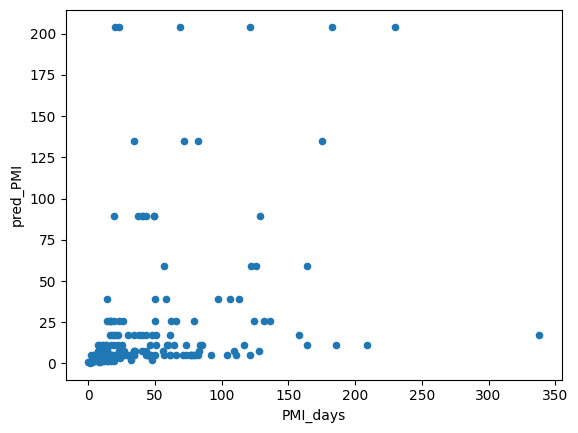

In [30]:
g_data3.plot.scatter(x = 'PMI_days', y = 'pred_PMI')
plt.show()

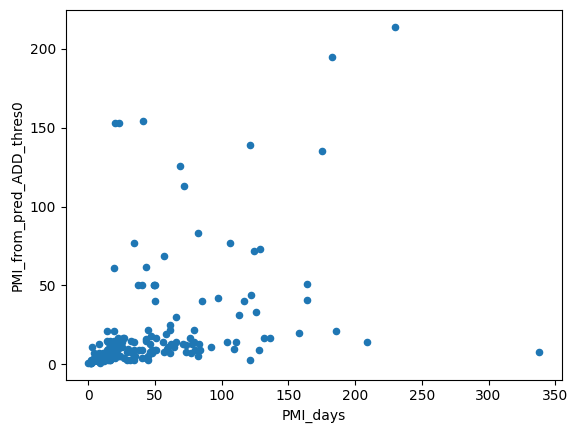

In [31]:
g_data3.plot.scatter(x = 'PMI_days', y = 'PMI_from_pred_ADD_thres0')
plt.show()